In [2]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import LSTM
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Convolution2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D

import kapre 
from kapre.time_frequency import Spectrogram

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

from itertools import islice

In [3]:
#import the data
A01T = h5py.File('/home/carla/Downloads/project_datasets/project_datasets/A01T_slice.mat','r')
data = np.copy(A01T['image'])
labels = np.copy(A01T['type'])
labels = labels[0,0:data.shape[0]:1]
labels = np.asarray(labels, dtype=np.int32)

#check the data dimensionality
print data.shape
print labels.shape

#for STFT we DO NOT swap the axes 
#data = np.swapaxes(data, 1,2)
data = data[:,:22,:]

(288, 25, 1000)
(288,)


In [4]:
#Experimental, try adding 24 zeros the the end of the matrix such that the shape is the same as in the paper
buf = np.zeros([288,22,24])
print buf.shape 
print data.shape
databuf = np.concatenate([data,buf],axis=2)
print databuf.shape

(288, 22, 24)
(288, 22, 1000)
(288, 22, 1024)


In [5]:
# Check min and max values
data = np.delete(data,56,0)
labels = np.delete(labels,56,0)
print data.shape
print labels.shape

(287, 22, 1000)
(287,)


In [6]:
#one-hot-encode the data for use with categorical_crossentropy
labels_cata = labels - 769
print labels_cata
labels_cata = to_categorical(labels_cata, num_classes=4)
print labels_cata

[3 2 1 0 0 1 2 3 1 2 0 0 0 3 1 1 0 0 2 0 1 3 3 2 0 3 3 1 3 3 1 0 1 2 2 2 3
 2 0 3 1 2 1 2 3 1 2 0 0 0 3 1 0 2 0 2 3 0 2 2 0 2 1 3 3 3 2 0 3 1 3 1 0 2
 1 0 2 2 0 2 3 3 1 0 1 3 1 3 2 1 1 1 2 3 0 1 3 0 2 2 3 0 0 2 1 3 3 3 1 0 2
 1 3 0 3 2 1 3 3 0 1 1 2 3 1 0 0 3 1 0 2 1 1 2 0 3 2 2 2 2 0 1 0 1 0 0 2 2
 1 2 3 0 3 0 0 1 3 2 1 3 2 3 2 3 1 1 3 0 1 1 1 2 3 0 3 0 2 0 3 0 2 0 1 2 2
 3 0 1 3 1 2 2 0 3 1 3 0 0 2 2 1 3 1 1 0 1 3 3 1 1 1 1 3 3 2 3 0 1 2 1 0 3
 0 3 0 0 0 0 2 2 3 1 2 2 2 3 2 0 2 0 3 1 3 3 2 3 3 2 1 3 2 0 1 1 1 2 1 3 2
 3 1 2 0 3 0 2 3 0 2 0 1 1 0 3 0 3 2 2 0 2 1 1 0 2 0 1 0]
[[ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 ..., 
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]]


In [34]:
#interwoven slicing
windows = 10
window_size = 512
step = int(float(data.shape[2]-window_size)/float(windows-1))
print step
data_sliced = np.zeros([data.shape[0]*windows,data.shape[1],window_size])
for t in range(data.shape[0]):
    for w in range(windows):
        data_slice = data[t,:,(w*step):window_size+(w*step)]
        data_sliced[(t*windows)+w] = data_slice
               
print data_sliced.shape 
labels_sliced  = np.repeat(labels_cata, windows,axis=0)
print labels_sliced.shape 

54
(2870, 22, 512)
(2870, 4)


In [9]:
#STFT CNN

SR = 250
src_cute, _ = librosa.load(r'/home/carla/Downloads/SampleAudio_0.4mb.mp3', sr=SR, mono=True)
print src_cute.shape

def print_info():
    print('%s/%s/%s' % (now.year, now.month, now.day))
    print('librosa version: {}'.format(librosa.__version__))
    print('Keras version: {}'.format(keras.__version__))
    if keras.backend._BACKEND == 'tensorflow':
        import tensorflow
        print('Keras backend: {}: {}'.format(keras.backend._backend, tensorflow.__version__))
    elif keras.backend._BACKEND == 'theano':
        import theano
        print('Keras backend: {}: {}'.format(keras.backend._backend, theano.__version__))
    print('Keras image data format: {}'.format(keras.backend.image_data_format()))
    print('Kapre version: {}'.format(kapre.__version__))
    print('\nSampling rate: {} Hz'.format(SR))

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])
    
    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    np.random.seed(42)
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, data, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print "Channels"
    print model.input_shape[1:]
    src = data 
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    print src_batch.shape
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    
    if logam:
        result = librosa.amplitude_to_db(result)
    display.specshow(result, 
                     y_axis='linear', sr=SR)

(6936,)


In [10]:
print_info()

2018/3/10
librosa version: 0.6.0
Keras version: 2.1.4
Keras backend: tensorflow: 1.5.0
Keras image data format: channels_last
Kapre version: 0.1.3

Sampling rate: 250 Hz


srcshape
(22, 512)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
trainable_stft (Spectrogr (None, 257, 64, 22)       263168      
Total params: 263,168
Trainable params: 263,168
Non-trainable params: 0
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 2s 767ms/step - loss: 1194.6475
Channels
(22, 512)
(1, 22, 512)
771


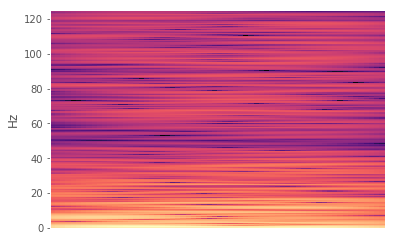

In [26]:
#Show the output of the model after STFT
src = data_sliced[0]
#src = databuf[0,0,:]
#src = src[np.newaxis, :] 
print "srcshape"
print src.shape
model = Sequential()
model.add(Spectrogram(n_dft=512, n_hop=8, input_shape=src.shape, 
          return_decibel_spectrogram=True, power_spectrogram=2.0, 
          trainable_kernel=True, name='trainable_stft'))

check_model(model)
visualise_model(model, src)
print labels[1]

In [35]:
#STFT Model
input_data = data_sliced
target_labels = labels_sliced
print "Data Shape: {}".format(input_data.shape)
model = Sequential()
model.add(Spectrogram(n_dft=512, n_hop=8, input_shape=input_data[0].shape, 
          return_decibel_spectrogram=True, power_spectrogram=2.0, 
          trainable_kernel=True, name='trainable_stft'))
model.add(Convolution2D(24,(12, 12)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Convolution2D(48,(8, 8)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Convolution2D(96,(4, 4)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(4, activation='softmax'))

model.summary(line_length=80, positions=[.33, .65, .8, 1.])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(input_data, target_labels, nb_epoch=10, batch_size=100, validation_split=0.1)
#model.fit(data, labels_cata, nb_epoch=1)
 
print "Done"

Data Shape: (2870, 22, 512)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
trainable_stft (Spectrogr (None, 257, 64, 22)       263168      
________________________________________________________________________________
conv2d_13 (Conv2D)        (None, 246, 53, 24)       76056       
________________________________________________________________________________
batch_normalization_13 (B (None, 246, 53, 24)       96          
________________________________________________________________________________
max_pooling2d_13 (MaxPool (None, 123, 26, 24)       0           
________________________________________________________________________________
activation_13 (Activation (None, 123, 26, 24)       0           
________________________________________________________________________________
dropout_13 (Dropout)      (None, 123, 26, 24)       0           
_______________________________